In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime

# Dependency imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Notebook Extentions
%load_ext tensorboard

# Japanese Language Classification

![title_banner](img/title_banner.jpg)

## Agenda

- This project is designed to take image recognition of Japanese characters, and create a learning model that can classify the characters based on the read input.
- Using the three main Japanese language writing systems (Kanji, Hiragana, Katakana), as well as the linguistically depreciated writing system of kuzushiji - used in Japan for over a thousand years since the 8th century.
- The data is from the ETL Character Database, which includes over a billion total of Japanese characters hand-written and reorganized by the National Institute of Advanced Industrial Science and Technology (AIST).

### The Writing Systems of Japan

- **Kanji:**
    - Kanji entered Japan in the 8th century via Chinese monks who also brought other traditions with them such as tea and Buddhism. Kanji is based on comparable Chinese characters that convey meaning from pictographic images.<br><br>

- **Hiragana:**
    - Phonetic writing system taking the mostly curviture root aspects of some kanji characters to represent a phonetic representation of sounds. There are 46 individual hiragana characters used today (alongside 29 diphthongs).<br><br>

- **Katakana:**
    - Much like hiragana, katakana is phonetically identical to hiragana. Katakana takes the angular aspects of some kanji characters and is mainly used for foreign words, onamatepeia, and sounds. Katakana contains the same amound of phonetic characters as hiragana.<br><br>

- **Kuzushiji:**
    - A cursive writing style, over 3 million books, on a diverse array of topics such as literature, science, mathematics and cooking written in kuzushiji are preserved today. However, the standardization of Japanese textbooks known as the “Elementary School Order” in 1900, removed Kuzushiji from regular school curriculum, as modern japanese print became popular. As a result, most Japanese natives today cannot read books written or printed in kuzushiji just 120 years ago.

## Data

### Data Information

- Each file contains 5 data sets except ETL8G_33.
- Each data set contains 956 characters written by a writer.
- Each writer wrote 10 sheets (genkouyoushi) per data set.

### Japanese Character Dataset Information

- **Hiragana (ETL 8):**
    - 71 hiragana characters (46 unique + 29 diphthongs)
    - 160 writers
    - 8199 records (genkouyoushi sheets) 
    - 1,254,120,000 unique handwritten hiragana characters (shared with kanji chars in the same files)<br><br>
    
- **Kanji (ETL 8):**
    - 883 daily use kanji
    - 160 writers
    - 8199 records 
    - 152,878,411 unique handwritten kanji (shared with hiragana chars in the same files)<br><br>
    
- **Katakana (ETL 1):**
    - 46 katakana characters (46 unique, dipthongs not included as they are phonetically identical to hiragana)
    - 1411 writers
    - 2052 records
    - 2,436,366 unique handwritten katakana characters

### Import & Read Hiragana

In [2]:
hira_kanji_record = 8199

In [ ]:
# Reading the Hiragana ETL8G File
def read_ETL8G(f):
    s = f.read(hira_kanji_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [ ]:
# Function to read the binary code present in each of the 33 files included in the ETL8G folder
def read_hiragana():
    # Characters = 71, writers = 160, y = 127, x = 128
    hiragana = np.zeros([71, 160, 127, 128], dtype = np.uint8)

    for j in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                            moji += 1
    np.savez_compressed('data/hiragana.npz', hiragana)

In [ ]:
# Running the Function Above
# read_hiragana()

In [ ]:
hiragana_data = np.load('data/hiragana.npz')
hira_test = hiragana_data.f.arr_0

In [ ]:
hira_test.shape

### Import & Read Kanji

In [ ]:
def read_kanji():
    # Characters = 883, writers = 160, y = 127, x = 128
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed('data/kanji.npz', kanji)

In [ ]:
# read_kanji()

In [ ]:
kanji_data = np.load('data/kanji.npz')
kanji_test = kanji_data.f.arr_0

In [ ]:
kanji_test.shape

### Import & Read Katakana

In [ ]:
kana_record = 2052

In [ ]:
# Reading in the Katakana ETL1 File
def read_ETL1(total_sheets, f):
    s = f.read(kana_record)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [ ]:
def read_katakana():
    # Character type = 46, writers = 1411, y = 63, x = 64
    katakana = np.zeros([46, 1411, 63, 64], dtype=np.uint8)
    counter = 0
    moji = 0
    for k in range(7, 14):
        filename = 'data/ETL1/ETL1C_{:02d}'.format(k)
        with open(filename, 'rb') as f:
            total_sheets = 0
            categories = 8
            if k == 13:
                categories = 3
            for j in range(categories):
                incrimenter = 0
                person = 0
                sheets = 1411
                if k == 9 and j == 4:
                    sheets = 1410
                elif k == 12 and j == 1:
                    sheets = 1410
                for i in range(sheets):
                    r = read_ETL1(total_sheets, f)
                    total_sheets += sheets
                    if k < 11 or (k >= 11 and b' I' not in r[1] and b' E' not in r[1] and b'WI' not in r[1] and b' U' not in r[1] and b'WE' not in r[1]):
                        pixels = np.array(r[-1])
                        for row in pixels:
                            for i in range(len(row)):
                                if row[i] == 1 or row[i] == 2:
                                    row[i] = 0
                        katakana[moji, person] = pixels
                        incrimenter = 1
                        person += 1
                moji += incrimenter
    np.savez_compressed('data/katakana.npz', katakana)

In [ ]:
# read_katakana()

In [ ]:
katakana_data = np.load('data/katakana.npz')
kana_test = katakana_data.f.arr_0

In [ ]:
kana_test.shape

## Visualizing Characters

### Visualizing Hiragana

In [ ]:
# Visualizing Hiragana
def visualize_hiragana():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2]:
                        print(r[:4])

In [ ]:
visualize_hiragana()

In [ ]:
def one_kana():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if b'.WO.' in r[2]:
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'img/kana_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [ ]:
one_kana()

- Kana Sample Visualization ![kana](img/kana_visualization.png)

### Visualizing Kanji

In [ ]:
def visualize_kanji():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                        print(r[:4])

In [ ]:
visualize_kanji()

In [ ]:
def one_kanji():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'img/kanji_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [ ]:
one_kanji()

- Kanji Sample Visualization: ![kanji](img/kanji_visualization.png)

## Feature Engineering

- The image dimensions need to be resized for the ML model to work on them. Initially images were resized to 32x32, but due to model performance, they were upsized to be 64x64.

In [2]:
# Image dimensions
img_row, img_col = 64, 64

### Resizing Hiragana Images

In [3]:
# 71 unique classes of hiragana (including dipthongs)
hiragana_class = 71

In [4]:
hiragana_writers = 160

In [5]:
hiragana_table = np.load('data/hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
hiragana_table = hiragana_table/np.max(hiragana_table)

In [6]:
hiragana_images = np.zeros([hiragana_class * hiragana_writers, img_row, img_col], dtype = np.float32)

for i in range(hiragana_class * hiragana_writers):
    hiragana_images[i] = skimage.transform.resize(hiragana_table[i], (img_row, img_col))

In [7]:
hiragana_images.shape

(11360, 64, 64)

### Resizing Kanji Images

In [8]:
# 879 unique classes of kanji (most daily used kanji)
kanji_class = 873

In [9]:
kanji_writers = 160

In [10]:
kanji_table = np.load('data/kanji.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
kanji_table = kanji_table/np.max(kanji_table)

- The kanji and hiragana characters share the ECT8 dataset, and they are not intuitively arranged. This accounts for this so hiragana are not mistakenly classified as kanji characters.

In [11]:
kanji_images = np.zeros([kanji_class * kanji_writers, img_row, img_col], dtype = np.float32)

for i in range((kanji_class + 4) * kanji_writers):
    if int(i / 160) != 88 and int( i / kanji_writers) != 219 and int( i / kanji_writers) != 349 and int( i / kanji_writers) != 457:
        if int(i / kanji_writers) < 88:
            kanji_images[i] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 88 and int(i / kanji_writers) < 219:
            kanji_images[i - kanji_writers] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 219 and int(i / kanji_writers) < 349:
            kanji_images[i - (kanji_writers * 2)] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 349 and int(i/160) < 457:
            if int(i / kanji_writers) > 457:
                kanji_images[i - (kanji_writers * 4)] = skimage.transform.resize(kanji_table[i], (img_row, img_col))

In [12]:
kanji_images.shape

(139680, 64, 64)

### Resizing Katakana Images

In [13]:
# 71 frequently used katakana characters (including dipthongs)
katakana_class = 46

In [14]:
katakana_writers = 1411

In [15]:
katakana_table = np.load('data/katakana.npz')['arr_0'].reshape([-1, 63, 64]).astype(np.float32)
katakana_table = katakana_table/np.max(katakana_table)

In [16]:
katakana_images = np.zeros([katakana_class * katakana_writers, img_row, img_col], dtype = np.float32)

for i in range(katakana_class * katakana_writers):
    katakana_images[i] = skimage.transform.resize(katakana_table[i], (img_row, img_col))

In [17]:
katakana_images.shape

(64906, 64, 64)

## Model Preparation

### Creating Labels

- Creating labels for multiclass classification for the three writing systems and merged datasets of them.

In [18]:
# Three classification types

y_labels_hiragana = np.zeros(hiragana_images.shape[0]) + 0
y_labels_kanji = np.zeros(kanji_images.shape[0]) + 1
y_labels_katakana = np.zeros(katakana_images.shape[0]) + 2

#### Merging Labels

In [19]:
merged_labels = np.concatenate([y_labels_hiragana, y_labels_kanji, y_labels_katakana])

In [20]:
merged_labels.shape

(215946,)

### Merging Dataset Images

In [21]:
merged_images = np.vstack([hiragana_images, kanji_images, katakana_images])
np.savez_compressed('data/merged_images.npz', merged_images)

In [22]:
merged_images.shape

(215946, 64, 64)

### Train-Test Split

#### Merged Train-Test Split

In [23]:
japanese_train, japanese_test, japanese_labels, japanese_test_labels = train_test_split(
                                                    merged_images,
                                                    merged_labels,
                                                    random_state=42,
                                                    test_size=0.2)

#### Creating Validation Set

- For classification of multiple input types and target variables, we need to create a cross-validation set as well as OneHotEncode our y values (y_train, y_val (validation set), y_test (labels)
- We will divide our X values by the number of classes to normalize our pixel values to be between 0 & 1

In [24]:
X_train, X_val, y_train, y_val =\
    train_test_split(japanese_train, japanese_labels, random_state = 42, test_size = 0.2)

X_train, X_val, X_test = X_train/np.max(X_train), X_val/np.max(X_val),\
                                        japanese_test/np.max(japanese_test)

In [32]:
# One Hot Encode our y values. Fit & transform on y train and only transform on our CV and test data.

japanese_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
y_train = japanese_ohe.fit_transform(y_train.reshape(-1, 1))
y_val = japanese_ohe.transform(y_val.reshape(-1, 1))
y_test = japanese_ohe.transform(japanese_test_labels.reshape(-1, 1))

#### Saving the Final Image Data

In [ ]:
# np.savez_compressed('data/japanese_X_train.npz', X_train)
# np.savez_compressed('data/japanese_X_validation.npz', X_val)
# np.savez_compressed('data/japanese_X_test.npz', X_test)
# np.savez_compressed('data/japanese_y_train.npz', y_train)
# np.savez_compressed('data/japanese_y_validation.npz', y_val)
# np.savez_compressed('data/japanese_y_test.npz', y_test)

## Visualization Tables

- Checking that our finalized data was extracted and correctly, and is readable in the correct visual format.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

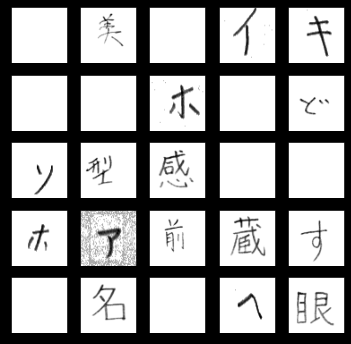

In [40]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
plt.show();

### Adding Variation with ImageDataGenerator

- Tensorflow's ImageDataGenerator can augment images to create new vesions of the data, essentially artificially inserting variation into the data
- Images can be rotated, zoomed, and flipped
- This variation is used to avoid overfitting on the training set
- Following augmentation is for a 2D CNN

#### Hiragana Augmentation

In [ ]:
# Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], 1, img_row, img_col)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], 1, img_row, img_col)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], 1, img_row, img_col)
    hira_shape = (1, img_row, img_col) 
else:
    hira_X_train = hira_X_train.reshape(hira_X_train.shape[0], img_row, img_col, 1)
    hira_X_test = hira_X_test.reshape(hira_X_test.shape[0], img_row, img_col, 1)
    hira_X_val = hira_X_val.reshape(hira_X_val.shape[0], img_row, img_col, 1)
    hira_shape = (img_row, img_col, 1) # For CNN

hiragana_datagen = ImageDataGenerator(rotation_range = 15, zoom_range = 0.2)

hiragana_datagen.fit(hira_X_train)

In [ ]:
hira_X_train.shape

In [ ]:
hira_X_val.shape